In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Load base heart failure data
print("Loading heart failure base data...")
hf_data = pd.read_csv('../datasets/heart_failure_base.csv')

Loading heart failure base data...


In [2]:
# Convert date columns
date_cols = ['admittime', 'dischtime', 'dob', 'next_admittime']
for col in date_cols:
    if col in hf_data.columns:
        hf_data[col] = pd.to_datetime(hf_data[col])

print(f"Initial dataset shape: {hf_data.shape}")

# Data Quality Assessment
print("\n=== DATA QUALITY ASSESSMENT ===")

# Check for missing values
missing_data = hf_data.isnull().sum()
missing_percent = (missing_data / len(hf_data)) * 100

Initial dataset shape: (21274, 34)

=== DATA QUALITY ASSESSMENT ===


In [3]:
print("Missing values analysis:")
for col, missing_count, missing_pct in zip(missing_data.index, missing_data.values, missing_percent.values):
    if missing_count > 0:
        print(f"{col}: {missing_count} ({missing_pct:.2f}%)")

# Handle missing values
print("\nHandling missing values...")

# Columns to drop (high missing or not useful)
cols_to_drop = ['edregtime', 'edouttime', 'deathtime', 'dod', 'dod_hosp', 'dod_ssn', 
                'row_id_x', 'row_id_y', 'has_chartevents_data', 'description', 'diagnosis']

hf_clean = hf_data.drop(columns=[col for col in cols_to_drop if col in hf_data.columns])

# Impute categorical variables
categorical_cols = ['admission_location', 'discharge_location', 'language', 'religion', 
                   'marital_status', 'insurance']


Missing values analysis:
admittime: 21274 (100.00%)
deathtime: 18489 (86.91%)
language: 5978 (28.10%)
religion: 81 (0.38%)
marital_status: 607 (2.85%)
edregtime: 7858 (36.94%)
edouttime: 7858 (36.94%)
diagnosis: 4 (0.02%)
dob: 20716 (97.38%)
dod: 8835 (41.53%)
dod_hosp: 12693 (59.66%)
dod_ssn: 11004 (51.73%)
los: 21274 (100.00%)
next_admittime: 21274 (100.00%)
days_to_readmit: 21274 (100.00%)

Handling missing values...


In [4]:
for col in categorical_cols:
    if col in hf_clean.columns:
        mode_val = hf_clean[col].mode()[0] if not hf_clean[col].mode().empty else 'Unknown'
        hf_clean[col].fillna(mode_val, inplace=True)

# Impute numerical variables
numerical_cols = ['age', 'los', 'days_to_readmit']
for col in numerical_cols:
    if col in hf_clean.columns:
        median_val = hf_clean[col].median()
        hf_clean[col].fillna(median_val, inplace=True)

print(f"Dataset shape after handling missing values: {hf_clean.shape}")

Dataset shape after handling missing values: (21274, 24)



=== OUTLIER DETECTION ===


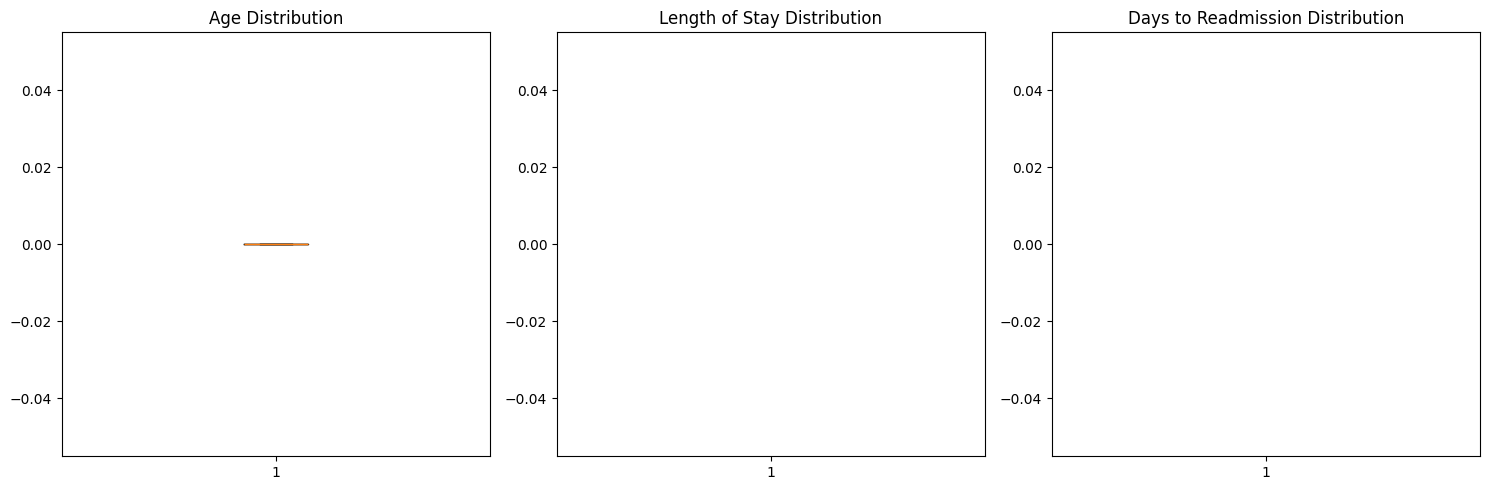

In [5]:
# Outlier Detection and Treatment
print("\n=== OUTLIER DETECTION ===")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Age outliers
axes[0].boxplot(hf_clean['age'].dropna())
axes[0].set_title('Age Distribution')

# LOS outliers
axes[1].boxplot(hf_clean['los'].dropna())
axes[1].set_title('Length of Stay Distribution')

# Days to readmit outliers
axes[2].boxplot(hf_clean[hf_clean['days_to_readmit'] > 0]['days_to_readmit'].dropna())
axes[2].set_title('Days to Readmission Distribution')

plt.tight_layout()
plt.show()

In [6]:
# Handle outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df


# Apply outlier treatment
hf_clean = handle_outliers(hf_clean, 'age')
hf_clean = handle_outliers(hf_clean, 'los')

print("Outliers handled for age and length of stay.")

Outliers handled for age and length of stay.


In [7]:
# Feature Engineering - Basic Demographics
print("\n=== BASIC FEATURE ENGINEERING ===")

# Create admission month and year
hf_clean['admission_month'] = hf_clean['admittime'].dt.month
hf_clean['admission_year'] = hf_clean['admittime'].dt.year

# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

hf_clean['admission_season'] = hf_clean['admission_month'].apply(get_season)

# Age groups
def age_group(age):
    if age < 45:
        return 'Young'
    elif age < 65:
        return 'Middle'
    elif age < 80:
        return 'Senior'
    else:
        return 'Elderly'

hf_clean['age_group'] = hf_clean['age'].apply(age_group)

# LOS categories
def los_category(los):
    if los <= 3:
        return 'Short'
    elif los <= 7:
        return 'Medium'
    elif los <= 14:
        return 'Long'
    else:
        return 'Very Long'

hf_clean['los_category'] = hf_clean['los'].apply(los_category)

print("Basic feature engineering completed.")

# Encode categorical variables
print("\n=== CATEGORICAL VARIABLE ENCODING ===")

categorical_features = ['gender', 'admission_type', 'admission_location', 
                       'discharge_location', 'insurance', 'language', 
                       'religion', 'marital_status', 'ethnicity',
                       'admission_season', 'age_group', 'los_category']



=== BASIC FEATURE ENGINEERING ===
Basic feature engineering completed.

=== CATEGORICAL VARIABLE ENCODING ===


In [8]:
# Label encoding for categorical variables
label_encoders = {}
for col in categorical_features:
    if col in hf_clean.columns:
        le = LabelEncoder()
        hf_clean[col] = le.fit_transform(hf_clean[col].astype(str))
        label_encoders[col] = le

print("Categorical variables encoded.")

# Save preprocessed data
hf_clean.to_csv('../datasets/heart_failure_cleaned.csv', index=False)
print(f"\nCleaned dataset saved. Shape: {hf_clean.shape}")
print(f"Columns: {list(hf_clean.columns)}")

# Final dataset overview
print("\n=== FINAL DATASET OVERVIEW ===")
print(hf_clean.info())
print(f"\nTarget variable distribution:")
print(hf_clean['readmission_30'].value_counts(normalize=True))

Categorical variables encoded.

Cleaned dataset saved. Shape: (21274, 29)
Columns: ['subject_id', 'hadm_id', 'seq_num', 'icd9_code', 'admittime', 'dischtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'hospital_expire_flag', 'row_id', 'gender', 'dob', 'expire_flag', 'age', 'los', 'next_admittime', 'days_to_readmit', 'readmission_30', 'admission_month', 'admission_year', 'admission_season', 'age_group', 'los_category']

=== FINAL DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21274 entries, 0 to 21273
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            21274 non-null  int64         
 1   hadm_id               21274 non-null  int64         
 2   seq_num               21274 non-null  float64       
 3   icd9_code             21274 non-null  int64         
 